<a href="https://colab.research.google.com/github/GarlandZhang/hairy_gan/blob/master/segmentation_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
project_path = '/content/drive/My Drive/hairy_gan/'
dataset_path = os.path.join(project_path, 'face_segment')
src_img_target_path = os.path.join(dataset_path, 'trainI')
label_img_target_path = os.path.join(dataset_path, 'trainS_original')

In [2]:
# from glob import glob
# import os
# import cv2
# import numpy as np
# from PIL import Image

# project_path = '/content/drive/My Drive/hairy_gan'
# files = glob(os.path.join(project_path, 'face_segment', 'trainS_original', '*.jpg'))
# target_folder = os.path.join(project_path, 'face_segment', 'trainS')
# if not os.path.exists(target_folder):
#   os.makedirs(target_folder)

# for f in files:
#   img = cv2.imread(f)
#   img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#   target_img = np.where(img == (255, 255, 0), 255, 0)[:, :, 0]
#   # print(f'{f} vs {os.path.join(target_folder, os.path.basename(f))}')
#   cv2.imwrite(os.path.join(target_folder, os.path.basename(f)), target_img)

In [3]:
# # move images and corresponding segmentation masks into their own folders
# if not os.path.exists(src_img_target_path):
#   os.makedirs(src_img_target_path)

# if not os.path.exists(label_img_target_path):
#   os.makedirs(label_img_target_path)
  
# tree = ET.parse(os.path.join(dataset_path, 'sampleset.xml'))
# root = tree.getroot()
# children = root.getchildren()
# for i in range(len(children) // 2):
#   src_img_path = children[2 * i].get('name').replace('\\', '/')
#   label_img_path = children[2 * i + 1].get('name').replace('\\', '/')
  
#   shutil.copy(os.path.join(dataset_path, src_img_path), os.path.join(src_img_target_path, os.path.basename(src_img_path)))
#   shutil.copy(os.path.join(dataset_path, label_img_path), os.path.join(label_img_target_path, os.path.basename(label_img_path)))

In [4]:
!git clone https://www.github.com/keras-team/keras-contrib.git \
    && cd keras-contrib \
    && pip install git+https://www.github.com/keras-team/keras-contrib.git \
    && python convert_to_tf_keras.py \
    && USE_TF_KERAS=1 python setup.py install

!pip install pillow
!pip install scipy==1.1.0        

Cloning into 'keras-contrib'...
remote: Enumerating objects: 3634, done.
remote: Total 3634 (delta 0), reused 0 (delta 0), pack-reused 3634
Receiving objects: 100% (3634/3634), 861.24 KiB | 1.98 MiB/s, done.
Resolving deltas: 100% (2330/2330), done.
  Cloning https://www.github.com/keras-team/keras-contrib.git to /tmp/pip-req-build-44joou7z
  Running command git clone -q https://www.github.com/keras-team/keras-contrib.git /tmp/pip-req-build-44joou7z
  Created wheel for keras-contrib: filename=keras_contrib-2.0.8-cp36-none-any.whl size=101064 sha256=130661536820fa793ce17bb2ffd3d309e4d96c66a8be76c32b4ca4e994bd21e3
  Stored in directory: /tmp/pip-ephem-wheel-cache-a1mo94fb/wheels/11/27/c8/4ed56de7b55f4f61244e2dc6ef3cdbaff2692527a2ce6502ba
Successfully built keras-contrib
Changed imports in 73 files.
Those files were found in the directory /content/keras-contrib
running install
running bdist_egg
running egg_info
creating tf_keras_contrib.egg-info
writing tf_keras_contrib.egg-info/PKG-INFO


In [5]:
import xml.etree.ElementTree as ET
import shutil

from __future__ import print_function, division
import scipy
from keras.datasets import mnist
from keras.models import Model, Sequential
from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, Concatenate
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.optimizers import Adam
from IPython.display import clear_output

import datetime
import matplotlib.pyplot as plt
import sys
import numpy as np
import os
import cv2

import PIL
from glob import glob

import tensorflow as tf

tf.compat.v1.disable_v2_behavior()
from tqdm import tqdm

Using TensorFlow backend.


Instructions for updating:
non-resource variables are not supported in the long term


In [6]:
class DataLoader():
    def __init__(self, dataset_path, img_res=(128, 128)):
      self.dataset_path = dataset_path
      self.img_res = img_res

    def load_data(self, domain, batch_size=1, is_testing=False):
      # data_type = "train%s" % domain if not is_testing else "test%s" % domain
      data_type = 'train' + domain # always grab from training since we have no test
      path = glob(os.path.join(self.dataset_path, data_type, '*'))

      batch_images = np.random.choice(path, size=batch_size)

      imgs = []
      for img_path in batch_images:
          img = self.imread(img_path)
          if not is_testing:
              img = scipy.misc.imresize(img, self.img_res)

              if np.random.random() > 0.5:
                  img = np.fliplr(img)
          else:
              img = scipy.misc.imresize(img, self.img_res)

          if domain == 'S':
            # super inefficient to this last but...
            img = np.expand_dims(img[:, :, 0], axis=-1)

          imgs.append(img)

      imgs = np.array(imgs)
      imgs = imgs /127.5 - 1.

      return imgs

    def load_batch(self, batch_size=1, is_testing=False):
      data_type = "train" if not is_testing else "val"

      folder_1 = os.path.join(self.dataset_path, data_type + 'I')
      folder_2 = os.path.join(self.dataset_path, data_type + 'S')
      path_I = glob(os.path.join(folder_1, '*'))
      path_S = glob(os.path.join(folder_2, '*'))

      self.n_batches = int(min(len(path_I), len(path_S)) / batch_size)
      total_samples = self.n_batches * batch_size

      # Sample n_batches * batch_size from each path list so that model sees all
      # samples from both domains
      path_I = np.random.choice(path_I, total_samples, replace=False)
      path_S = np.array([glob(os.path.join(os.path.dirname(path), '../', 'trainS', '*'))[0] for path in path_I])
      # path_S = np.random.choice(path_S, total_samples, replace=False)

      i = 0
      while True:
          batch_I = path_I[i*batch_size:(i+1)*batch_size]
          batch_S = path_S[i*batch_size:(i+1)*batch_size]
          imgs_I, imgs_S = [], []
          for img_I, img_S in zip(batch_I, batch_S):
              img_I = self.imread(img_I)
              img_S = self.imread(img_S)

              img_I = scipy.misc.imresize(img_I, self.img_res)
              img_S = scipy.misc.imresize(img_S, self.img_res)

              if not is_testing and np.random.random() > 0.5:
                      img_I = np.fliplr(img_I)
                      img_S = np.fliplr(img_S)

              # super inefficient to this last but...
              img_S = np.expand_dims(img_S[:, :, 0], axis=-1)

              imgs_I.append(img_I)
              imgs_S.append(img_S)

          imgs_I = np.array(imgs_I)/127.5 - 1.
          imgs_S = np.array(imgs_S) / 255.
          
          i += 1

          if i == self.n_batches - 1:
            path_I = np.random.choice(path_I, total_samples, replace=False)
            path_S = np.array([glob(os.path.join(os.path.dirname(path), '../', 'trainS', '*'))[0] for path in path_I])
            # path_S = np.random.choice(path_S, total_samples, replace=False)
            i = 0
          yield imgs_I, imgs_S

    def imread(self, path):
      return scipy.misc.imread(path, mode='RGB').astype(np.float)

In [111]:
class SegGAN():
  def __init__(self):
    self.img_rows = 128
    self.img_cols = 128
    self.img_channels = 3

    self.img_shape = (self.img_rows, self.img_cols, self.img_channels)

    self.data_loader = DataLoader(dataset_path, img_res=(self.img_rows, self.img_cols))

    # patch = int(self.img_rows / 2**4)
    # self.disc_patch = (patch, patch, 1) # output shape of discriminator
    self.segment_shape = self.img_shape[:-1] + (1,)

    self.gf = 32 # num filters in first layer of gen
    self.df = 64 # num filters in first layer of disc

    optimizer = Adam(0.0002, 0.5, 0.999)

    self.d_I = self.build_discriminator()
    self.d_S = self.build_discriminator(segment=True)

    self.d_I.compile(loss='mse', optimizer=optimizer, metrics=['accuracy'])
    self.d_S.compile(loss='mse', optimizer=optimizer, metrics=['accuracy'])

    self.d_I_output_shape = tuple(self.d_I.layers[-1].output.get_shape().as_list()[1:])
    self.d_S_output_shape = tuple(self.d_S.layers[-1].output.get_shape().as_list()[1:])

    self.g_IS = self.build_generator(segment=True)
    self.g_SI = self.build_generator()

    if os.path.exists(os.path.join(project_path, 'd_I.weights')):
      self.d_I.load_weights(os.path.join(project_path, 'd_I.weights'))

    if os.path.exists(os.path.join(project_path, 'd_S.weights')):
      self.d_S.load_weights(os.path.join(project_path, 'd_S.weights'))

    if os.path.exists(os.path.join(project_path, 'g_IS.weights')):
      self.g_IS.load_weights(os.path.join(project_path, 'g_IS.weights'))

    if os.path.exists(os.path.join(project_path, 'g_SI.weights')):
      self.g_SI.load_weights(os.path.join(project_path, 'g_SI.weights'))

    img_I = Input(shape=self.img_shape)
    img_S = Input(shape=self.segment_shape)

    fake_S = self.g_IS(img_I)
    fake_I = self.g_SI(img_S)

    reconstr_I = self.g_SI(fake_S)
    reconstr_S = self.g_IS(fake_I)

    valid_I = self.d_I(fake_I)
    valid_S = self.d_S(fake_S)

    self.combined = Model(inputs=[img_I, img_S], outputs=[valid_I, valid_S, fake_S, fake_I, reconstr_I, reconstr_S])
    self.combined.compile(loss=['mse', 'mse', 'binary_crossentropy', 'mse', 'mae', 'binary_crossentropy'], loss_weights=[1, 1, 1, 1, 1, 0.05], optimizer=optimizer)

  def build_generator(self, segment=False):
    '''U-net generator'''

    def conv2d(layer_input, filters, f_size=4):
      '''Layers used during downsampling'''
      d = Conv2D(filters, kernel_size=f_size, strides=2, padding='same')(layer_input)
      d = LeakyReLU(alpha=0.2)(d)
      d = InstanceNormalization()(d)
      return d

    def deconv2d(layer_input, skip_input, filters, f_size=4, dropout_rate=0):
      '''Layers used during upsampling'''
      u = UpSampling2D(size=2)(layer_input)
      u = Conv2D(filters, kernel_size=f_size, strides=1, padding='same', activation='relu')(u)

      if dropout_rate:
        u = Dropout(dropout_rate)(u)
      u = InstanceNormalization()(u)
      u = Concatenate()([u, skip_input])
      return u

    if segment:
      d0 = Input(shape=self.img_shape)
    else:
      d0 = Input(shape=self.segment_shape)
    d1 = conv2d(d0, self.gf)
    d2 = conv2d(d1, self.gf * 2)
    d3 = conv2d(d2, self.gf * 4)
    d4 = conv2d(d3, self.gf * 8)

    u1 = deconv2d(d4, d3, self.gf * 4)
    u2 = deconv2d(u1, d2, self.gf * 2)
    u3 = deconv2d(u2, d1, self.gf)

    u4 = UpSampling2D(size=2)(u3)

    if not segment:
      output_img = Conv2D(self.img_channels, kernel_size=4, strides=1, padding='same', activation='tanh')(u4)
    else:
      output_img = Conv2D(1, kernel_size=4, strides=1, padding='same', activation='sigmoid')(u4)

    return Model(d0, output_img)

  def build_discriminator(self, segment=False):
  
    if not segment:
      input = Input(shape=self.img_shape)
    else:
      input = Input(shape=self.segment_shape)
    d1 = Conv2D(self.df, kernel_size=1, strides=1, padding='same')(input)
    d2 = LeakyReLU(alpha=0.2)(d1)
    d3 = Conv2D(self.df * 2, kernel_size=1, strides=1, padding='same')(d2)
    d4 = BatchNormalization()(d3)
    d5 = LeakyReLU(alpha=0.2)(d4)
    d6 = Conv2D(self.df * 2, kernel_size=1, strides=1, padding='same', activation='sigmoid')(d5)

    return Model(input, d6)

  def train(self, epochs, batch_size=1, sample_interval=50, verbose=True):
    start_time = datetime.datetime.now()

    valid_I = np.ones((batch_size, ) + self.d_I_output_shape)
    fake_gen_I = np.zeros((batch_size, ) + self.d_I_output_shape)

    valid_S = np.ones((batch_size, ) + self.d_S_output_shape)
    fake_gen_S = np.zeros((batch_size, ) + self.d_S_output_shape)

    batch_gen = self.data_loader.load_batch(batch_size)
    for i, elem in enumerate(batch_gen):
      break

    for epoch in range(epochs):
      steps_per_epoch = self.data_loader.n_batches
      for batch_i in tqdm(range(steps_per_epoch), desc=f'Train {epoch} / {epochs}', total=steps_per_epoch):
        if not verbose:
          clear_output()
        imgs_I, imgs_S = next(batch_gen)
        fake_S = self.g_IS.predict(imgs_I)
        fake_I = self.g_SI.predict(imgs_S)

        dI_loss_real = self.d_I.fit(imgs_I, valid_I)
        dI_loss_fake = self.d_I.fit(fake_I, fake_gen_I)

        # dI_loss = 0.5 * np.add(dI_loss_real, dI_loss_fake)

        dS_loss_real = self.d_S.fit(imgs_S, valid_S)
        dS_loss_fake = self.d_S.fit(fake_S, fake_gen_S)

        # dS_loss = 0.5 * np.add(dS_loss_real, dS_loss_fake)

        # d_loss = 0.5 * np.add(dI_loss, dS_loss)

        g_loss = self.combined.fit([imgs_I, imgs_S], [fake_gen_I, fake_gen_S, imgs_S, imgs_I, imgs_I, imgs_S])

        if batch_i % sample_interval == 0:
          self.sample_images(epoch, batch_i)

          # save weights (cannot save model because eager behavior disabled)
          self.d_I.save_weights('d_I.weights')
          shutil.copy('d_I.weights', os.path.join(project_path, 'd_I.weights'))

          self.d_S.save_weights('d_S.weights')
          shutil.copy('d_S.weights', os.path.join(project_path, 'd_S.weights'))

          self.g_IS.save_weights('g_IS.weights')
          shutil.copy('g_IS.weights', os.path.join(project_path, 'g_IS.weights'))

          self.g_SI.save_weights('g_SI.weights')
          shutil.copy('g_SI.weights', os.path.join(project_path, 'g_SI.weights'))
  
  def sample_images(self, epoch, batch_i):
    format_size = 20
    print('=' * format_size)

    r, c = 2, 3

    imgs_I = self.data_loader.load_data(domain="I", batch_size=1, is_testing=True)
    imgs_S = self.data_loader.load_data(domain="S", batch_size=1, is_testing=True)
    
    # Translate images to the other domain
    fake_S = self.g_IS.predict(imgs_I)
    fake_I = self.g_SI.predict(imgs_S)
    # Translate back to original domain
    reconstr_I = self.g_SI.predict(fake_S)
    reconstr_S = self.g_IS.predict(fake_I)

    # super inefficient but works..
    imgs_S = self.batch_gray_to_rgb((imgs_S + 1) * 127.5)
    fake_S = self.batch_gray_to_rgb(self.post_process(fake_S))
    reconstr_S = self.batch_gray_to_rgb(self.post_process(reconstr_S))

    imgs_I = self.post_process(imgs_I)
    fake_I = self.post_process(fake_I)
    reconstr_I = self.post_process(reconstr_I)

    gen_imgs = np.concatenate([imgs_I, fake_S, reconstr_I, imgs_S, fake_I, reconstr_S])

    # Rescale images 0 - 1
    # gen_imgs = 0.5 * gen_imgs + 0.5

    titles = ['Original', 'Translated', 'Reconstructed']
    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i,j].imshow(gen_imgs[cnt])
            axs[i, j].set_title(titles[j])
            axs[i,j].axis('off')
            cnt += 1
    plt.show()

    print('=' * format_size)

    return gen_imgs

  def post_process(self, batch):
    if batch.shape[-1] == 1:
      return batch * 255.
    else:
      return ((batch + 1.) * 127.5) / 255.

  def batch_gray_to_rgb(self, batch):
    return np.array([cv2.cvtColor(np.squeeze(img).astype(np.uint8), cv2.COLOR_GRAY2RGB) for img in batch])

In [112]:
gan = SegGAN()
# gan.train(epochs=10000, batch_size=5, sample_interval=100, verbose=True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:87: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


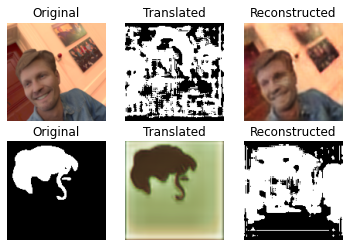

In [113]:
imgs = gan.sample_images(1, 1)

In [108]:
imgs = gan.data_loader.load_data(domain="S", batch_size=1, is_testing=True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:87: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


In [110]:
imgs[0].max()

1.0